<a href="https://colab.research.google.com/github/mohammad-nour-alawad/HH-Data-Analysis-Salary-Prediction/blob/main/hh_data_analysis_salary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up the Spark Environment


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=87227ceb9823f70f59ef3083e3d2fd54edfee75b7b09aa2a02ed169bd6180f4b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, split, expr, when
from pyspark.sql.types import IntegerType, StringType, BooleanType, DoubleType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Initialize Spark session
spark = SparkSession.builder \
    .appName("HH Analysis") \
    .getOrCreate()


# 2. Read the Data

In [ ]:
!unzip /content/drive/MyDrive/HH/dst-3.0_16_1_hh_database.zip -d /content/

Archive:  /content/drive/MyDrive/HH/dst-3.0_16_1_hh_database.zip
  inflating: /content/dst-3.0_16_1_hh_database.csv  


In [ ]:
# Load data
hh_df = spark.read.csv('/content/dst-3.0_16_1_hh_database.csv', sep=';', header=True, inferSchema=True)
hh_df.show(5)

+--------------------+-----------+-------------------------+----------------------------+--------------------+--------------------+--------------------+-------------------------------+----------------------------+--------------------+-----------------+--------------------+
|        Пол, возраст|         ЗП|Ищет работу на должность:|Город, переезд, командировки|           Занятость|              График|         Опыт работы|Последнее/нынешнее место работы|Последняя/нынешняя должность|   Образование и ВУЗ|Обновление резюме|                Авто|
+--------------------+-----------+-------------------------+----------------------------+--------------------+--------------------+--------------------+-------------------------------+----------------------------+--------------------+-----------------+--------------------+
|Мужчина ,  39 лет...| 29000 руб.|     Системный админис...|        Советск (Калининг...|частичная занятос...|гибкий график, по...|"Опыт работы 16 л...|           "МАОУ ""СОШ № 1

# 3. Data Exploration
Explore the structure and schema of the DataFrame:

In [ ]:
hh_df.printSchema()
hh_df.describe().show()

root
 |-- Пол, возраст: string (nullable = true)
 |-- ЗП: string (nullable = true)
 |-- Ищет работу на должность:: string (nullable = true)
 |-- Город, переезд, командировки: string (nullable = true)
 |-- Занятость: string (nullable = true)
 |-- График: string (nullable = true)
 |-- Опыт работы: string (nullable = true)
 |-- Последнее/нынешнее место работы: string (nullable = true)
 |-- Последняя/нынешняя должность: string (nullable = true)
 |-- Образование и ВУЗ: string (nullable = true)
 |-- Обновление резюме: string (nullable = true)
 |-- Авто: string (nullable = true)

+-------+--------------------+----------+-------------------------+----------------------------+--------------------+--------------------+--------------------+-------------------------------+----------------------------+--------------------+--------------------+--------------------+
|summary|        Пол, возраст|        ЗП|Ищет работу на должность:|Город, переезд, командировки|           Занятость|              Графи

# 4. Data Cleaning and Transformation

## 4.1 Extract Education Level

In [ ]:
# Define a UDF to extract education level
def extract_education(value):
    if value is None:
        return None
    if "Высшее" in value:
        return "высшее"
    elif "Неоконченное" in value:
        return "неоконченное высшее"
    elif "Среднее специальное" in value:
        return "среднее специальное"
    elif "Среднее" in value:
        return "среднее"
    else:
        return None

# Register the UDF
extract_education_udf = udf(extract_education, StringType())

# Apply the UDF
hh_df = hh_df.withColumn("Образование", extract_education_udf(col("Образование и ВУЗ")))

# Drop the original column
hh_df = hh_df.drop("Образование и ВУЗ")


## 4.2 Extract Gender and Age

In [ ]:
from pyspark.sql.functions import regexp_extract

# Extract Gender and Age
hh_df = hh_df.withColumn("Пол", split(col("Пол, возраст"), " , ").getItem(0)) \
    .withColumn("Возраст", regexp_extract(col("Пол, возраст"), r'(\d+)', 1).cast(IntegerType())) \
    .drop("Пол, возраст")

## 4.3 Extract Work Experience

In [ ]:

# Define a UDF to calculate experience in months
def calculate_experience(value):
    if value is None or value == "Не указано":
        return None
    years = 0
    months = 0
    parts = value.split()
    for i, part in enumerate(parts):
        if part in ["год", "года", "лет"]:
            try:
                years = int(parts[i-1])
            except ValueError:
                years = 0
        if part in ["месяц", "месяца", "месяцев"]:
            try:
                months = int(parts[i-1])
            except ValueError:
                months = 0
    return years * 12 + months

calculate_experience_udf = udf(calculate_experience, IntegerType())

# Apply the UDF to extract experience
hh_df = hh_df.withColumn("Опыт работы (месяц)", calculate_experience_udf(col("Опыт работы"))) \
    .drop("Опыт работы")

# Remove rows with more than 600 months of experience
max_experience_months = 600
hh_df = hh_df.filter((col("Опыт работы (месяц)") <= max_experience_months) & (col("Опыт работы (месяц)") > 0))


# calculate_experience_udf = udf(calculate_experience, IntegerType())

# # Apply the UDF to extract experience
# hh_df = hh_df.withColumn("Опыт работы (месяц)", calculate_experience_udf(col("Опыт работы"))) \
#     .drop("Опыт работы")

# # Check the Spark DataFrame schema and show few rows
# hh_df.printSchema()
# hh_df.show(5)

# # Verify the number of rows
# row_count = hh_df.count()
# print(f'Number of rows in the DataFrame: {row_count}')

# # Investigate the distribution of experience data
# hh_df.select("Опыт работы (месяц)").describe().show()
# hh_df.select("Опыт работы (месяц)").orderBy(col("Опыт работы (месяц)").desc()).show(10)

# # # Filter out unrealistic values for work experience
# # # Remove negative values and set an upper bound (e.g., 50 years = 600 months)
# # max_experience_months = 600
# # hh_df_filtered = hh_df.filter((col("Опыт работы (месяц)") <= max_experience_months) & (col("Опыт работы (месяц)") > 0))

# # # Verify the number of rows after filtering
# # filtered_row_count = hh_df_filtered.count()
# # print(f'Number of rows after filtering: {filtered_row_count}')

# # # Convert to Pandas DataFrame
# # experience_data_filtered = hh_df_filtered.select("Опыт работы (месяц)").toPandas()
# # experience_data_filtered["Опыт работы (год)"] = experience_data_filtered["Опыт работы (месяц)"] / 12

# # # Plot the histogram
# # plt.figure(figsize=(10, 6))
# # sns.histplot(experience_data_filtered["Опыт работы (год)"], bins=30)
# # plt.title("Распределение опыта работы соискателей")
# # plt.xlabel("Опыт работы (год)")
# # plt.ylabel("Количество")
# # plt.show()


Explanation
- Remove Negative and Excessively High Values: The script filters out any negative values and values exceeding a reasonable upper bound (e.g., 600 months).
- Convert to Pandas DataFrame: Converts the filtered Spark DataFrame to a Pandas DataFrame.
- Plots the histogram of the filtered data.

## 4.4 Extract City, Relocation, and Business Trip Readiness

In [ ]:
# Define UDFs to extract city, relocation readiness, and business trip readiness
def extract_city(value):
    city = value.split(" , ")[0]
    million_cities = ['Новосибирск', 'Екатеринбург', 'Нижний Новгород', 'Казань', 'Челябинск',
                      'Омск', 'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Пермь',
                      'Воронеж', 'Волгоград']
    if city == 'Москва' or city == 'Санкт-Петербург':
        return city
    elif city in million_cities:
        return "город миллионник"
    else:
        return "другие"

def extract_relocation(value):
    if "не готов" in value:
        return False
    return True

def extract_business_trip(value):
    if "не готов" in value:
        return False
    return True

# Register the UDFs
extract_city_udf = udf(extract_city, StringType())
extract_relocation_udf = udf(extract_relocation, BooleanType())
extract_business_trip_udf = udf(extract_business_trip, BooleanType())

# Apply the UDFs
hh_df = hh_df.withColumn("Город", extract_city_udf(col("Город, переезд, командировки"))) \
    .withColumn("Готовность к переезду", extract_relocation_udf(col("Город, переезд, командировки"))) \
    .withColumn("Готовность к командировкам", extract_business_trip_udf(col("Город, переезд, командировки"))) \
    .drop("Город, переезд, командировки")


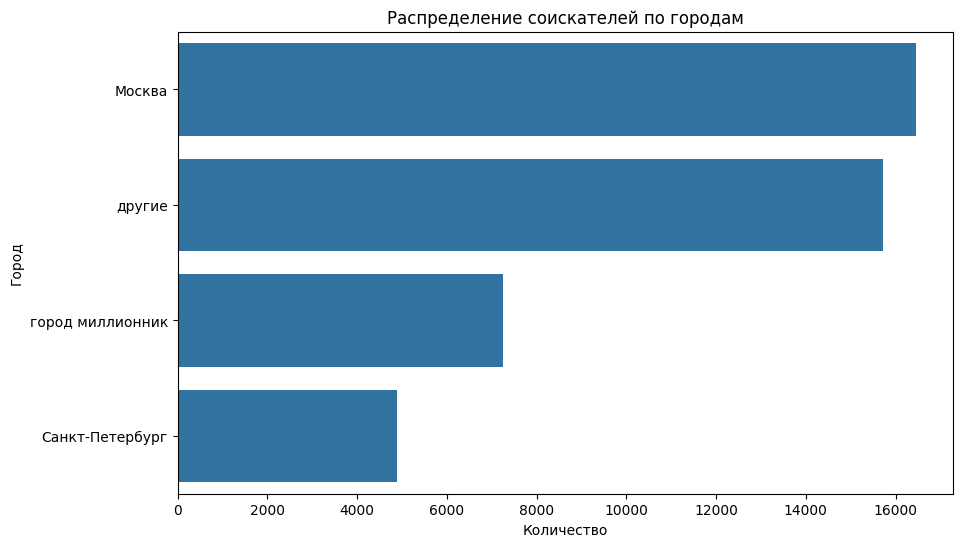

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert relevant columns to Pandas DataFrame
city_data = hh_df.select("Город").toPandas()
relocation_data = hh_df.select("Готовность к переезду").toPandas()
business_trip_data = hh_df.select("Готовность к командировкам").toPandas()

# Plotting distribution of cities
plt.figure(figsize=(10, 6))
sns.countplot(y=city_data["Город"], order=city_data["Город"].value_counts().index)
plt.title("Распределение соискателей по городам")
plt.xlabel("Количество")
plt.ylabel("Город")
plt.show()

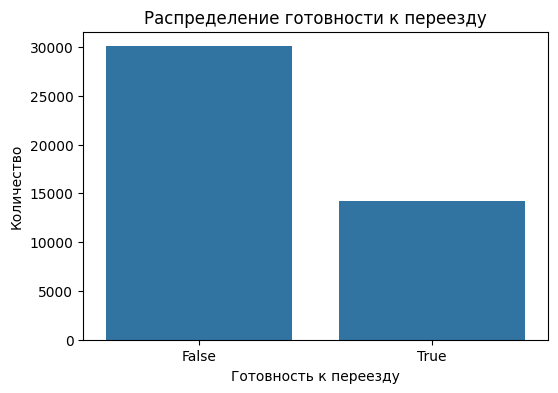

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=relocation_data["Готовность к переезду"])
plt.title("Распределение готовности к переезду")
plt.xlabel("Готовность к переезду")
plt.ylabel("Количество")
plt.show()

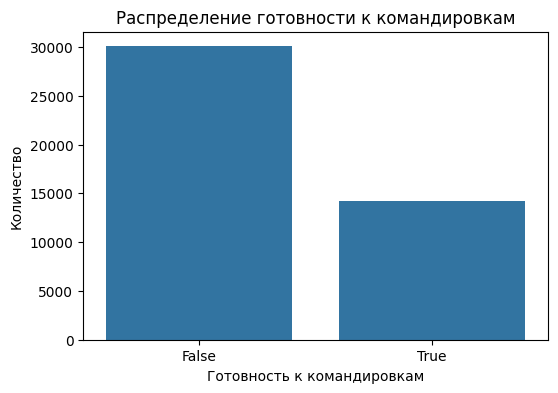

In [ ]:
# Plotting distribution of readiness for business trips
plt.figure(figsize=(6, 4))
sns.countplot(x=business_trip_data["Готовность к командировкам"])
plt.title("Распределение готовности к командировкам")
plt.xlabel("Готовность к командировкам")
plt.ylabel("Количество")
plt.show()

## 4.5 One Hot Encoding for Employment and Schedule

In [ ]:
# One Hot Encoding for Employment
employment_types = ["полная занятость", "частичная занятость", "проектная работа", "волонтерство", "стажировка"]
for employment in employment_types:
    hh_df = hh_df.withColumn(employment, col("Занятость").contains(employment))

# One Hot Encoding for Schedule
schedule_types = ["полный день", "сменный график", "гибкий график", "удаленная работа", "вахтовый метод"]
for schedule in schedule_types:
    hh_df = hh_df.withColumn(schedule, col("График").contains(schedule))

# Drop original columns
hh_df = hh_df.drop("Занятость", "График")

## 4.6 Convert Salary to RUB

In [ ]:
# Load exchange rates data
rates = spark.read.csv("/content/drive/MyDrive/HH/ExchangeRates.csv", header=True, inferSchema=True)

# Extract salary amount and currency
def extract_salary(value):
    return float(value.split(' ')[0])

def extract_currency(value):
    return value.split(' ')[1].replace('.', '')

# Register UDFs
extract_salary_udf = udf(extract_salary, DoubleType())
extract_currency_udf = udf(extract_currency, StringType())

# Apply the UDFs
hh_df = hh_df.withColumn("ЗП (tmp)", extract_salary_udf(col("ЗП"))) \
    .withColumn("Валюта", extract_currency_udf(col("ЗП"))) \
    .withColumn("Обновление резюме", col("Обновление резюме").cast('date'))

# Join with exchange rates
hh_df = hh_df.join(rates, (hh_df["Валюта"] == rates["currency"]) & (hh_df["Обновление резюме"] == rates["date"]), "left_outer")

# Fill missing values
hh_df = hh_df.fillna({'close': 1, 'proportion': 1})

# Calculate salary in RUB
hh_df = hh_df.withColumn("ЗП (руб)", col("ЗП (tmp)") * col("close") / col("proportion"))

# Drop temporary columns
hh_df = hh_df.drop("ЗП", "ЗП (tmp)", "Валюта", "currency", "date", "close", "proportion")


# 5. Data Analysis
For data analysis, we can perform similar operations as in pandas but using PySpark functions. Here are a few examples:


## 5.1 Distribution of Age

In [ ]:
# Check the Spark DataFrame schema and show few rows
hh_df.printSchema()
hh_df.show(5)

root
 |-- Ищет работу на должность:: string (nullable = true)
 |-- Последнее/нынешнее место работы: string (nullable = true)
 |-- Последняя/нынешняя должность: string (nullable = true)
 |-- Обновление резюме: date (nullable = true)
 |-- Авто: string (nullable = true)
 |-- Образование: string (nullable = true)
 |-- Пол: string (nullable = true)
 |-- Возраст: integer (nullable = true)
 |-- Опыт работы (месяц): integer (nullable = true)
 |-- Город: string (nullable = true)
 |-- Готовность к переезду: boolean (nullable = true)
 |-- Готовность к командировкам: boolean (nullable = true)
 |-- полная занятость: boolean (nullable = true)
 |-- частичная занятость: boolean (nullable = true)
 |-- проектная работа: boolean (nullable = true)
 |-- волонтерство: boolean (nullable = true)
 |-- стажировка: boolean (nullable = true)
 |-- полный день: boolean (nullable = true)
 |-- сменный график: boolean (nullable = true)
 |-- гибкий график: boolean (nullable = true)
 |-- удаленная работа: boolean (nulla

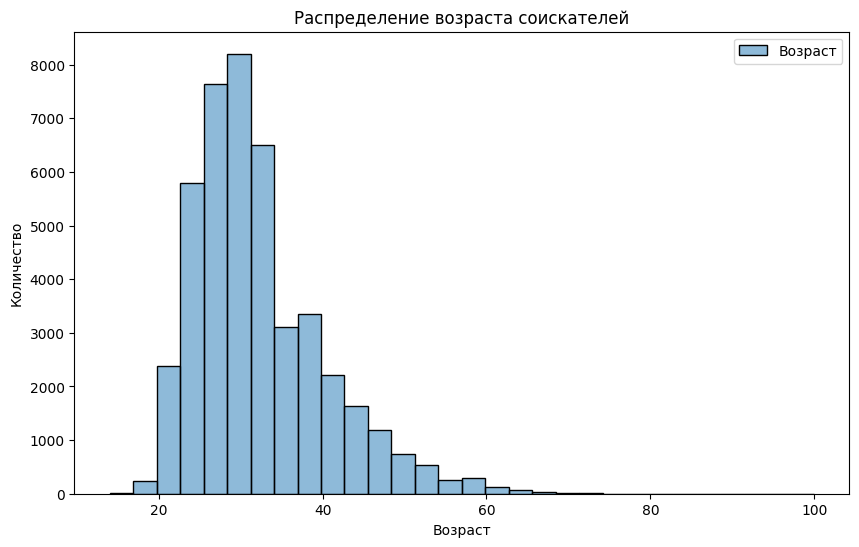

In [ ]:
# Convert to Pandas for visualization
age_data = hh_df.select("Возраст").toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(age_data, bins=30)
plt.title("Распределение возраста соискателей")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

## 5.2 Distribution of Work Experience

In [ ]:
# Check the statistics of the 'Опыт работы (месяц)' column
hh_df.select("Опыт работы (месяц)").describe().show()

# Display some of the extreme values to investigate
hh_df.select("Опыт работы (месяц)").orderBy(col("Опыт работы (месяц)").desc()).show(10)


+-------+-------------------+
|summary|Опыт работы (месяц)|
+-------+-------------------+
|  count|              44291|
|   mean| 48.997222912104036|
| stddev| 49.425201978512895|
|    min|                  1|
|    max|                549|
+-------+-------------------+

+-------------------+
|Опыт работы (месяц)|
+-------------------+
|                549|
|                545|
|                530|
|                518|
|                511|
|                507|
|                500|
|                496|
|                495|
|                489|
+-------------------+
only showing top 10 rows



Number of rows after filtering: 44291


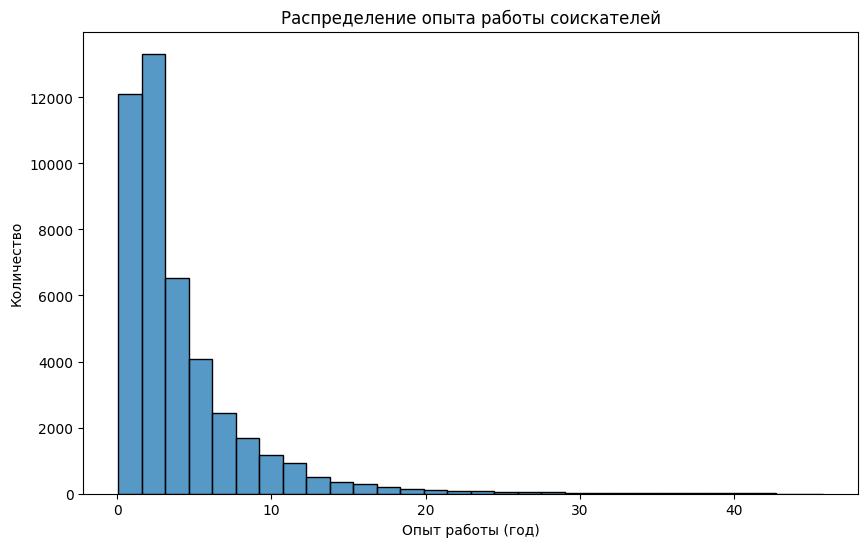

In [ ]:
max_experience_months = 600
hh_df_filtered = hh_df.filter((col("Опыт работы (месяц)") <= max_experience_months) & (col("Опыт работы (месяц)") > 0))

# Verify the number of rows after filtering
filtered_row_count = hh_df_filtered.count()
print(f'Number of rows after filtering: {filtered_row_count}')

# Convert to Pandas DataFrame
experience_data_filtered = hh_df_filtered.select("Опыт работы (месяц)").toPandas()
experience_data_filtered["Опыт работы (год)"] = experience_data_filtered["Опыт работы (месяц)"] / 12

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(experience_data_filtered["Опыт работы (год)"], bins=30)
plt.title("Распределение опыта работы соискателей")
plt.xlabel("Опыт работы (год)")
plt.ylabel("Количество")
plt.show()

# 6. Further Visualization


## 6.1. Distribution of Salaries


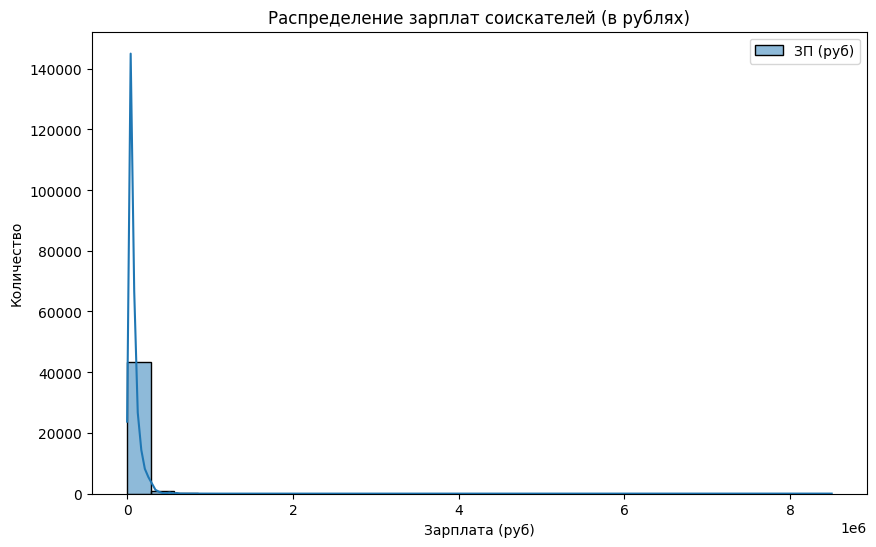

In [ ]:
# Convert to Pandas DataFrame
salary_data = hh_df.select("ЗП (руб)").toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(salary_data, bins=30, kde=True)
plt.title("Распределение зарплат соискателей (в рублях)")
plt.xlabel("Зарплата (руб)")
plt.ylabel("Количество")
plt.show()


## Remove Outliers and Visualize Data Again

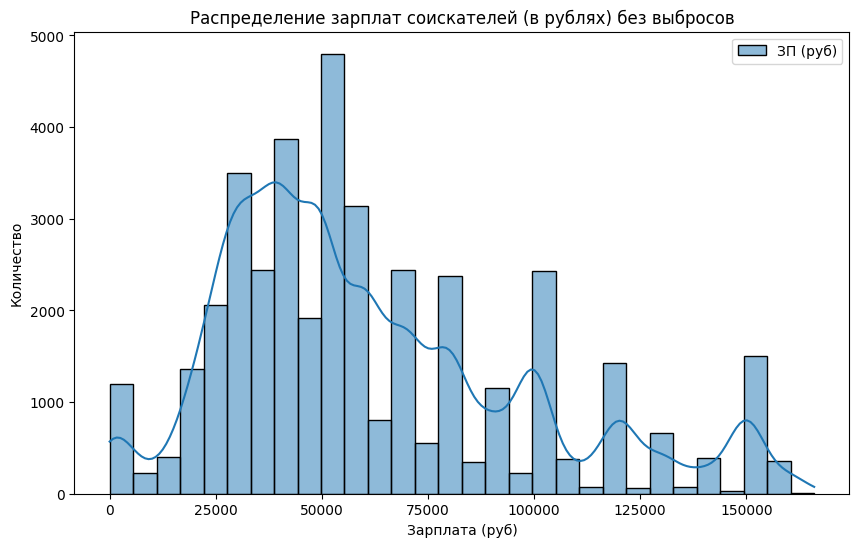

In [ ]:
from pyspark.sql.functions import col

# Calculate Q1 and Q3
Q1 = hh_df.approxQuantile("ЗП (руб)", [0.25], 0.05)[0]
Q3 = hh_df.approxQuantile("ЗП (руб)", [0.75], 0.05)[0]
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
hh_df = hh_df.filter((col("ЗП (руб)") >= lower_bound) & (col("ЗП (руб)") <= upper_bound))

# Convert to Pandas for visualization
filtered_salary_data = hh_df.select("ЗП (руб)").toPandas()

# Plot the filtered data
plt.figure(figsize=(10, 6))
sns.histplot(filtered_salary_data, bins=30, kde=True)
plt.title("Распределение зарплат соискателей (в рублях) без выбросов")
plt.xlabel("Зарплата (руб)")
plt.ylabel("Количество")
plt.show()


## 6.2. Salary Distribution by Education Level


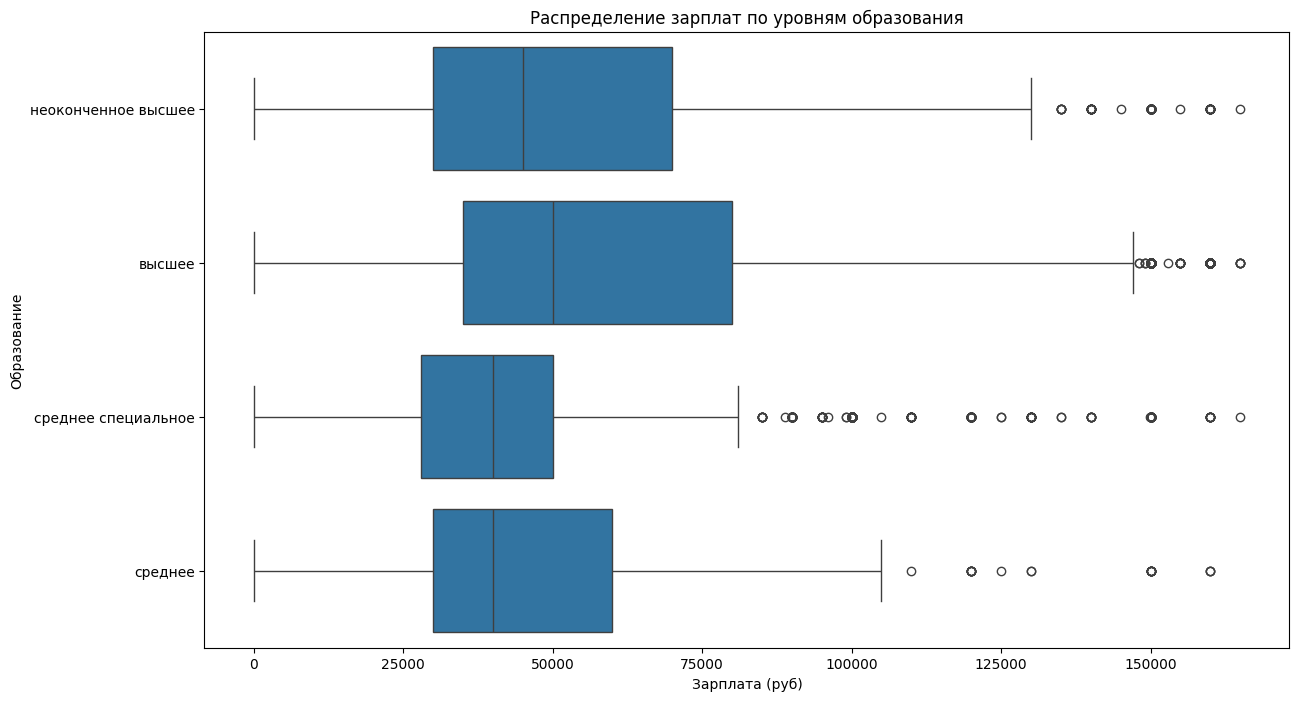

In [ ]:
# Convert to Pandas DataFrame
salary_education_data = hh_df.select("ЗП (руб)", "Образование").toPandas()

# Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x="ЗП (руб)", y="Образование", data=salary_education_data)
plt.title("Распределение зарплат по уровням образования")
plt.xlabel("Зарплата (руб)")
plt.ylabel("Образование")
plt.show()

## Log Transformation


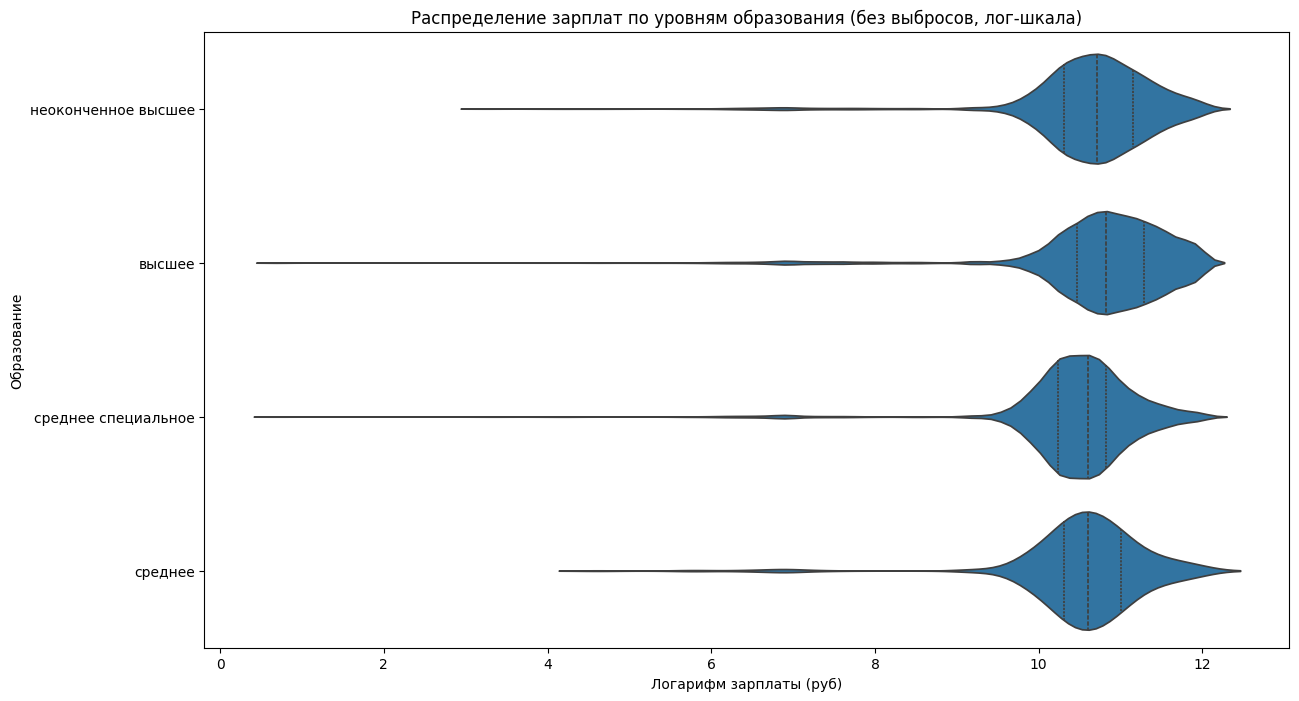

In [ ]:
import numpy as np

salary_education_data["ЗП (руб)"] = np.log1p(salary_education_data["ЗП (руб)"])

# Plot
plt.figure(figsize=(14, 8))
sns.violinplot(x="ЗП (руб)", y="Образование", data=salary_education_data, inner="quartile")
plt.title("Распределение зарплат по уровням образования (без выбросов, лог-шкала)")
plt.xlabel("Логарифм зарплаты (руб)")
plt.ylabel("Образование")
plt.show()


**Log Transformation: np.log1p is used to apply a log transformation (log(1 + salary)) to reduce skewness.**

## 6.3. Average Salary by City

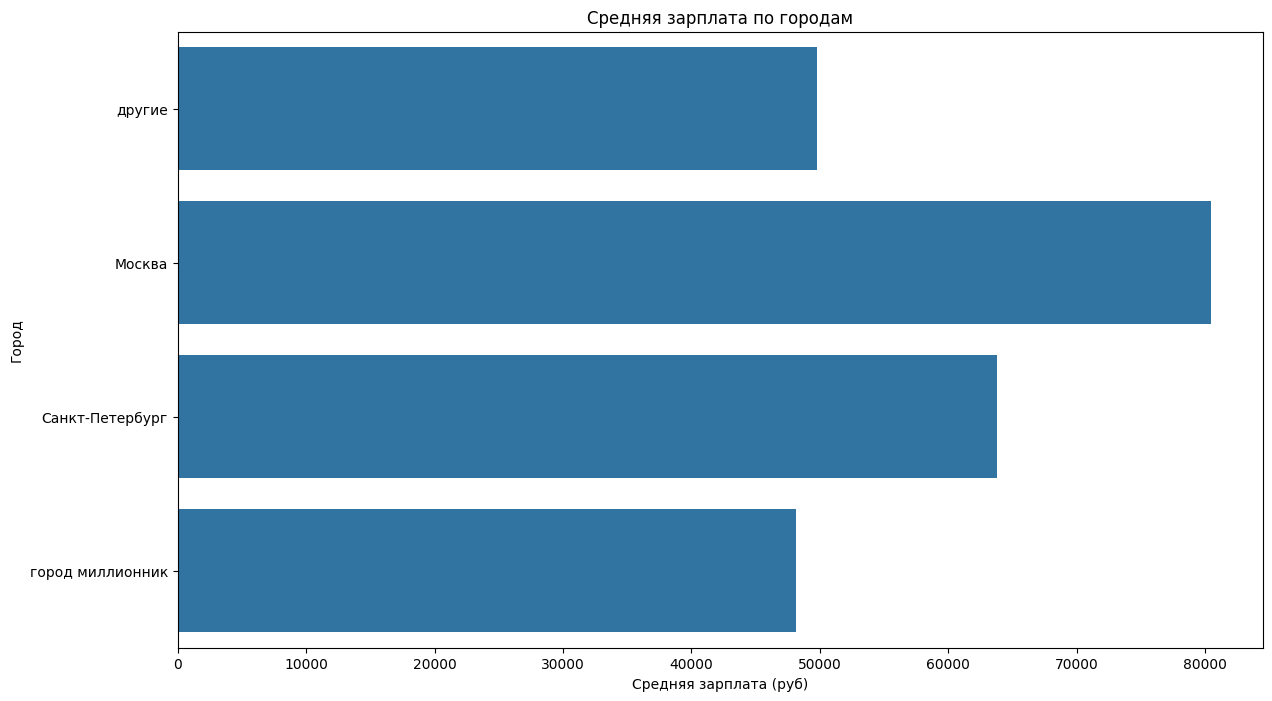

In [ ]:
# Group by city and calculate average salary
avg_salary_by_city = hh_df.groupBy("Город").avg("ЗП (руб)").toPandas()

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x="avg(ЗП (руб))", y="Город", data=avg_salary_by_city)
plt.title("Средняя зарплата по городам")
plt.xlabel("Средняя зарплата (руб)")
plt.ylabel("Город")
plt.show()

## 6.4. Gender Distribution


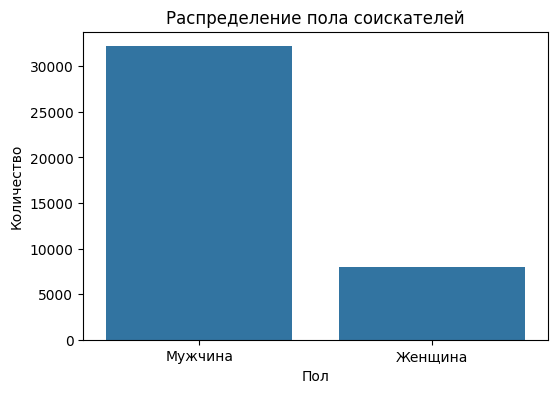

In [ ]:
# Convert to Pandas DataFrame
gender_data = hh_df.select("Пол").toPandas()

# Plot
plt.figure(figsize=(6, 4))
sns.countplot(x=gender_data["Пол"])
plt.title("Распределение пола соискателей")
plt.xlabel("Пол")
plt.ylabel("Количество")
plt.show()

## 6.5. Education Level Distribution


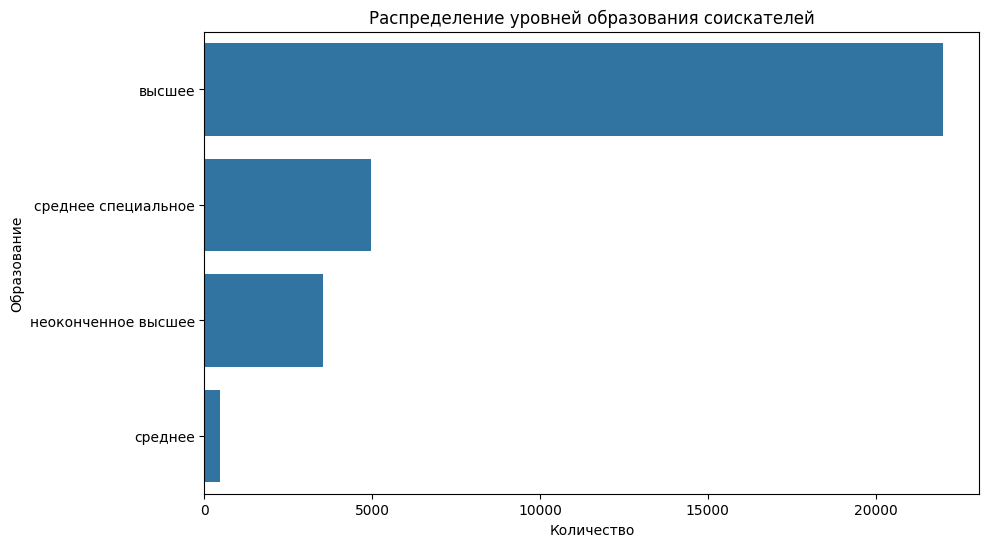

In [ ]:
# Convert to Pandas DataFrame
education_data = hh_df.select("Образование").toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(y=education_data["Образование"], order=education_data["Образование"].value_counts().index)
plt.title("Распределение уровней образования соискателей")
plt.xlabel("Количество")
plt.ylabel("Образование")
plt.show()

## 6.6. Salary Distribution by Gender


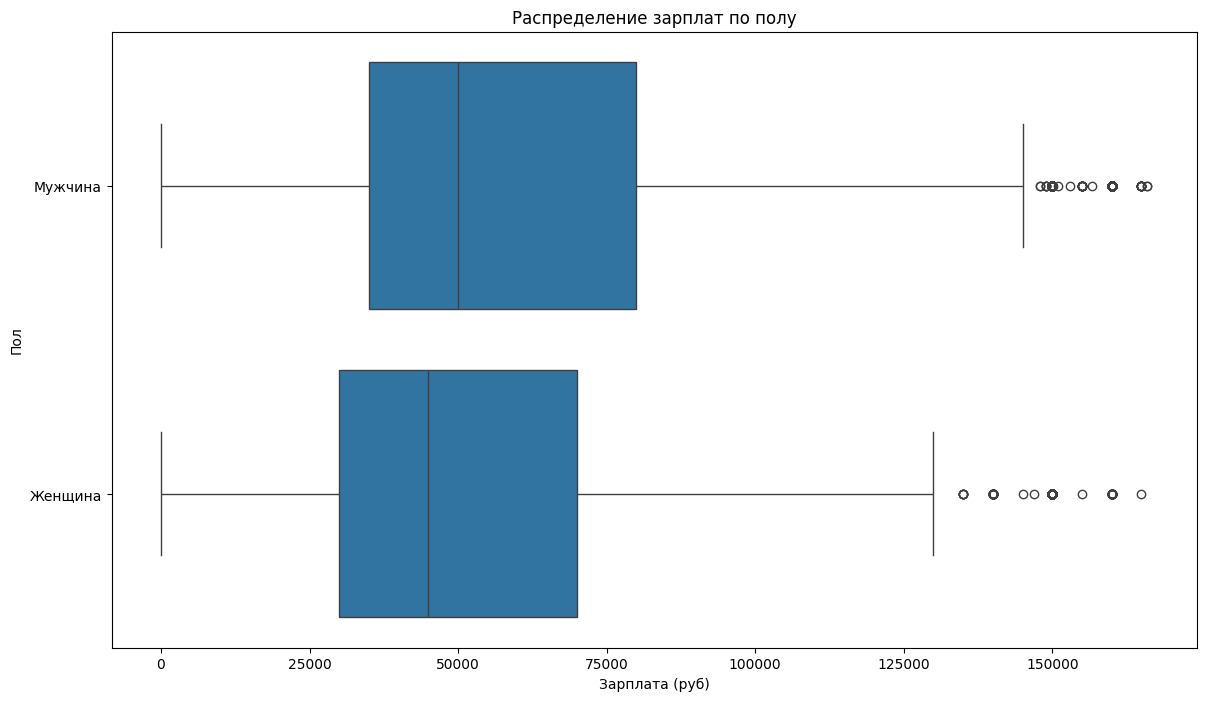

In [ ]:
# Convert to Pandas DataFrame
salary_gender_data = hh_df.select("ЗП (руб)", "Пол").toPandas()

# Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x="ЗП (руб)", y="Пол", data=salary_gender_data)
plt.title("Распределение зарплат по полу")
plt.xlabel("Зарплата (руб)")
plt.ylabel("Пол")
plt.show()

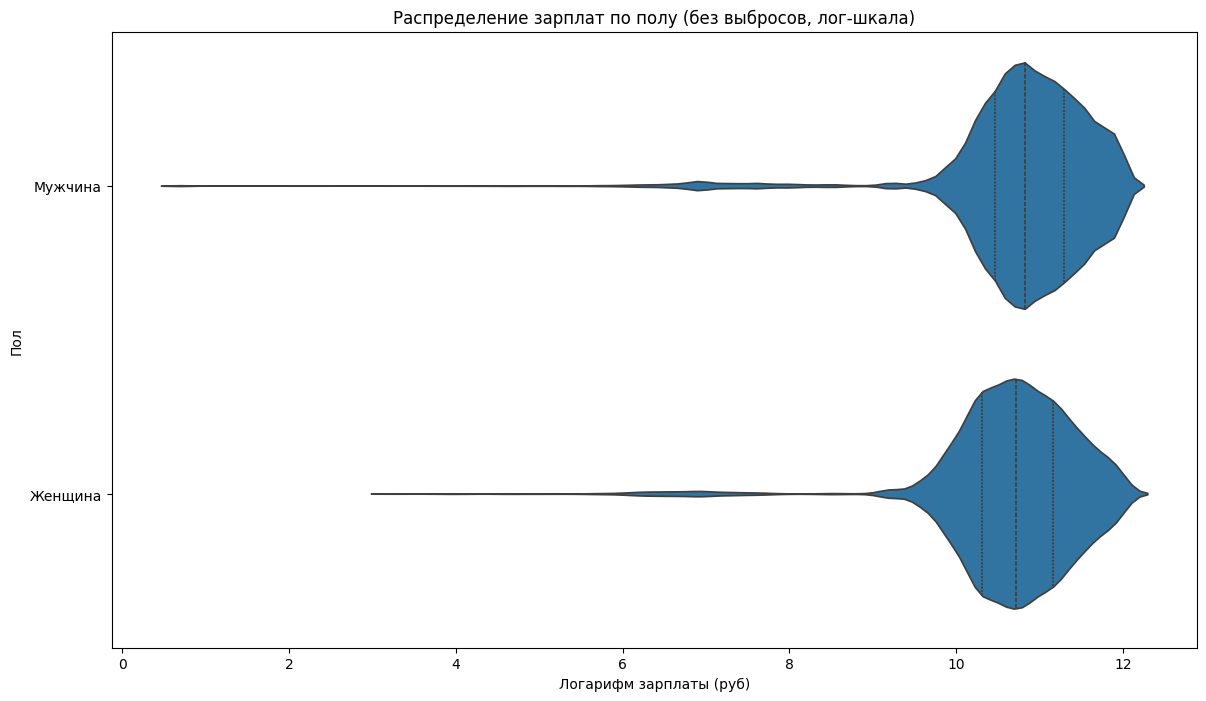

In [ ]:
import numpy as np

# Apply log transformation
salary_gender_data["ЗП (руб)"] = np.log1p(salary_gender_data["ЗП (руб)"])

# Plot
plt.figure(figsize=(14, 8))
sns.violinplot(x="ЗП (руб)", y="Пол", data=salary_gender_data, inner="quartile")
plt.title("Распределение зарплат по полу (без выбросов, лог-шкала)")
plt.xlabel("Логарифм зарплаты (руб)")
plt.ylabel("Пол")
plt.show()

## 6.7. Readiness for Relocation and Business Trips by Gender


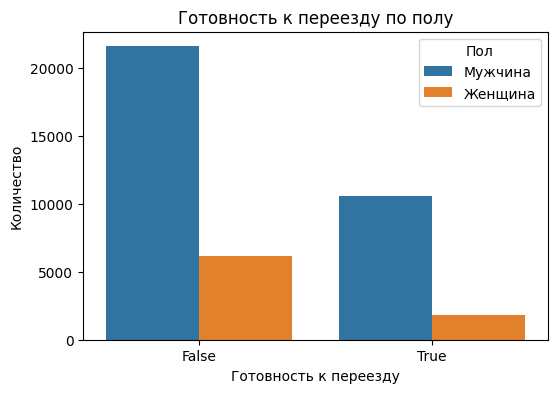

In [ ]:
# Convert to Pandas DataFrame
relocation_gender_data = hh_df.select("Готовность к переезду", "Пол").toPandas()
business_trip_gender_data = hh_df.select("Готовность к командировкам", "Пол").toPandas()

# Plot for relocation readiness
plt.figure(figsize=(6, 4))
sns.countplot(x="Готовность к переезду", hue="Пол", data=relocation_gender_data)
plt.title("Готовность к переезду по полу")
plt.xlabel("Готовность к переезду")
plt.ylabel("Количество")
plt.show()

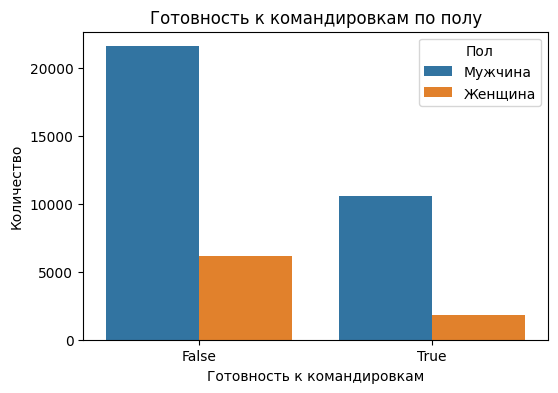

In [ ]:
# Plot for business trip readiness
plt.figure(figsize=(6, 4))
sns.countplot(x="Готовность к командировкам", hue="Пол", data=business_trip_gender_data)
plt.title("Готовность к командировкам по полу")
plt.xlabel("Готовность к командировкам")
plt.ylabel("Количество")
plt.show()

## 6.8. Employment Type and Schedule Preferences


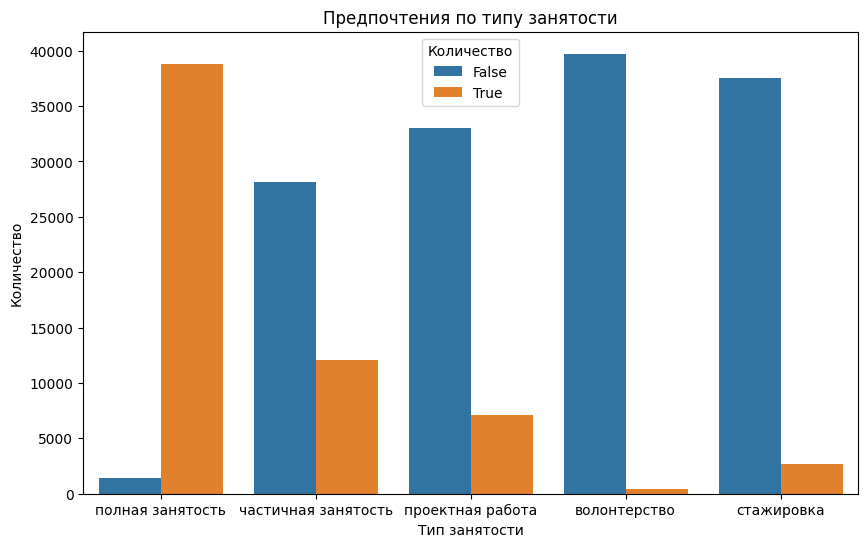

In [ ]:
# Employment types
employment_cols = ["полная занятость", "частичная занятость", "проектная работа", "волонтерство", "стажировка"]
employment_data = hh_df.select(employment_cols).toPandas()
employment_data = employment_data.melt(var_name="Занятость", value_name="Количество")

# Plot for employment types
plt.figure(figsize=(10, 6))
sns.countplot(x="Занятость", hue="Количество", data=employment_data)
plt.title("Предпочтения по типу занятости")
plt.xlabel("Тип занятости")
plt.ylabel("Количество")
plt.show()

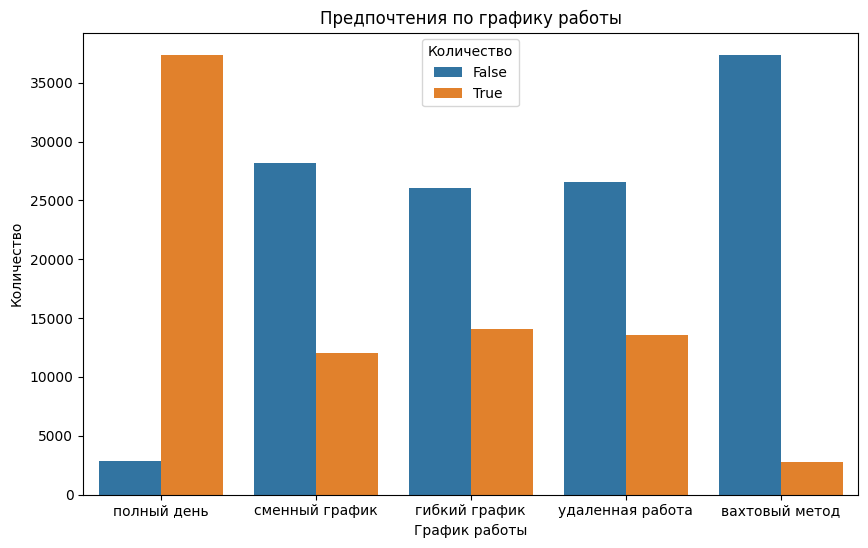

In [ ]:
# Schedule types
schedule_cols = ["полный день", "сменный график", "гибкий график", "удаленная работа", "вахтовый метод"]
schedule_data = hh_df.select(schedule_cols).toPandas()
schedule_data = schedule_data.melt(var_name="График", value_name="Количество")

# Plot for schedule types
plt.figure(figsize=(10, 6))
sns.countplot(x="График", hue="Количество", data=schedule_data)
plt.title("Предпочтения по графику работы")
plt.xlabel("График работы")
plt.ylabel("Количество")
plt.show()

## 6.9. Salary Distribution by City and Education Level

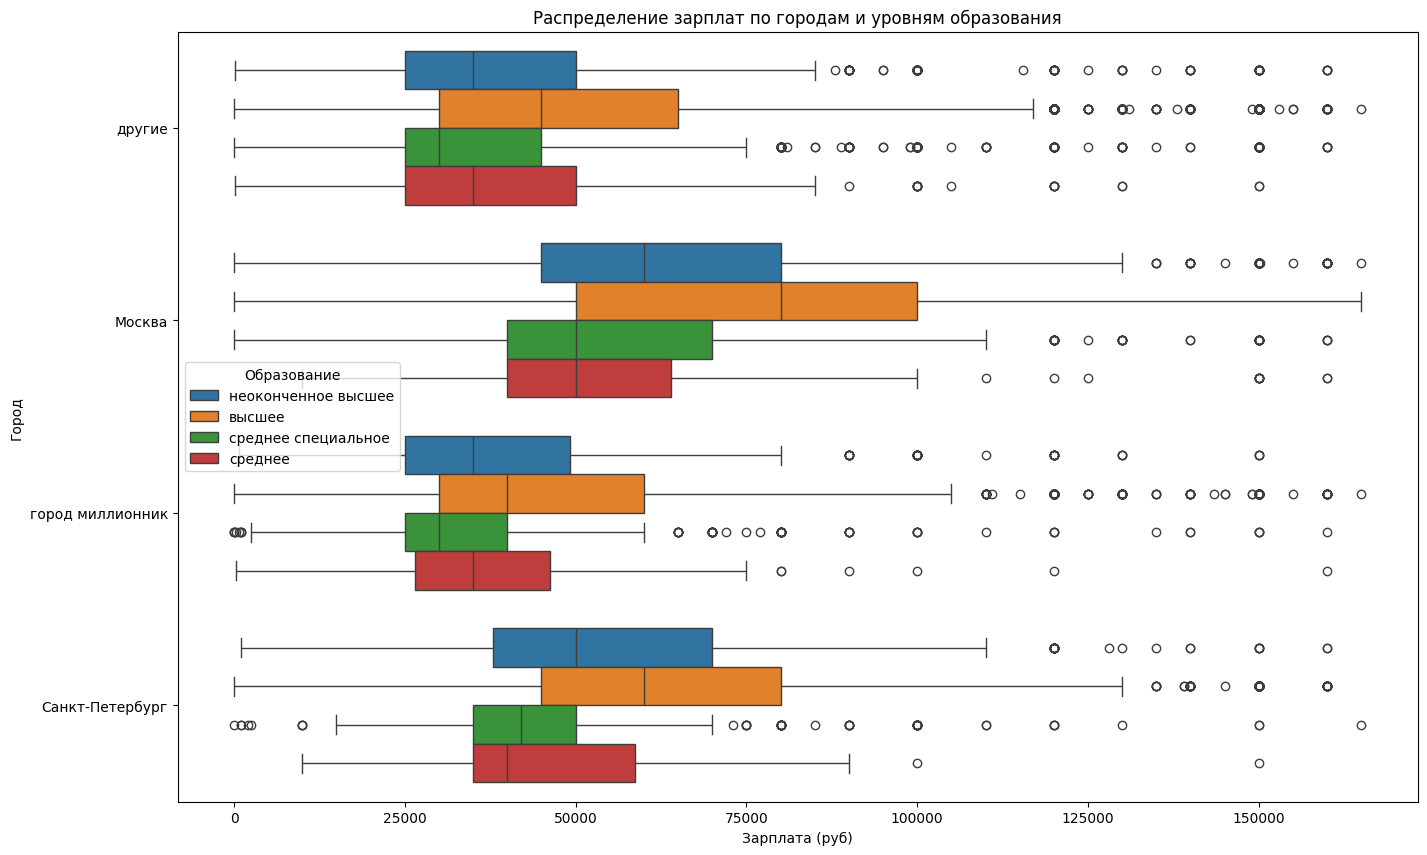

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame
salary_city_education_data = hh_df.select("ЗП (руб)", "Город", "Образование").toPandas()

# Plot
plt.figure(figsize=(16, 10))
sns.boxplot(x="ЗП (руб)", y="Город", hue="Образование", data=salary_city_education_data)
plt.title("Распределение зарплат по городам и уровням образования")
plt.xlabel("Зарплата (руб)")
plt.ylabel("Город")
plt.legend(title="Образование")
plt.show()

## 6.10. Heatmap of Employment Types and Schedule Preferences


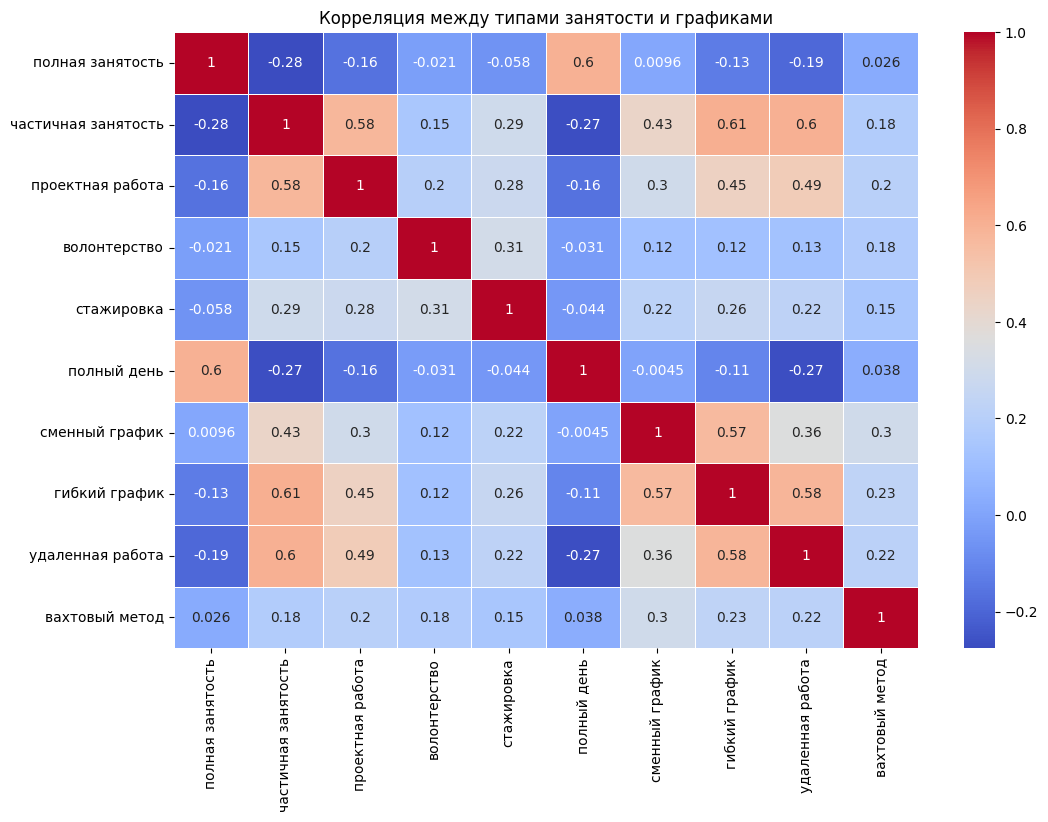

In [ ]:
# Convert to Pandas DataFrame
employment_schedule_data = hh_df.select("полная занятость", "частичная занятость", "проектная работа", "волонтерство", "стажировка",
                                        "полный день", "сменный график", "гибкий график", "удаленная работа", "вахтовый метод").toPandas()

# Compute correlation matrix
corr_matrix = employment_schedule_data.corr()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Корреляция между типами занятости и графиками")
plt.show()

## 6.11. 3D Scatter Plot of Age, Salary, and Work Experience


In [ ]:
import plotly.express as px

# Convert to Pandas DataFrame
age_salary_experience_data = hh_df.select("Возраст", "ЗП (руб)", "Опыт работы (месяц)").toPandas()

# Plot
fig = px.scatter_3d(age_salary_experience_data, x='Возраст', y='ЗП (руб)', z='Опыт работы (месяц)',
                    title="Взаимосвязь возраста, зарплаты и опыта работы",
                    labels={"Возраст": "Возраст", "ЗП (руб)": "Зарплата (руб)", "Опыт работы (месяц)": "Опыт работы (месяц)"})
fig.show()

## 6.12. Cluster Analysis of Job Seekers


Fill Missing Values: Using the median of each column to fill NaN values.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



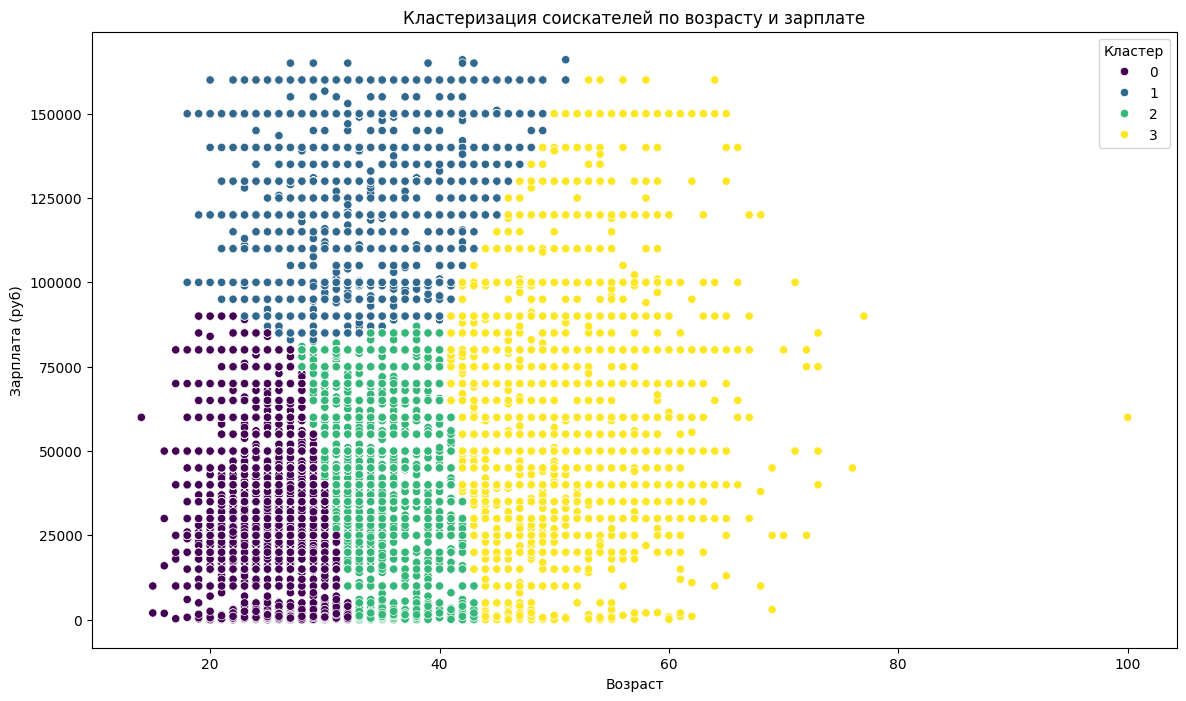

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select relevant features
cluster_data = hh_df.select("Возраст", "ЗП (руб)").toPandas()

# Fill missing values with the median of each column
filtered_cluster_data = cluster_data.fillna(cluster_data.median())

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_cluster_data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
filtered_cluster_data["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot
plt.figure(figsize=(14, 8))
sns.scatterplot(data=filtered_cluster_data, x="Возраст", y="ЗП (руб)", hue="Cluster", palette="viridis")
plt.title("Кластеризация соискателей по возрасту и зарплате")
plt.xlabel("Возраст")
plt.ylabel("Зарплата (руб)")
plt.legend(title="Кластер")
plt.show()

lets also consider work experience "Опыт работы (месяц)" and do it in 3D

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Select relevant features
cluster_data = hh_df.select("Возраст", "ЗП (руб)", "Опыт работы (месяц)").toPandas()

# Fill missing values with the median of each column
filtered_cluster_data = cluster_data.fillna(cluster_data.median())

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_cluster_data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
filtered_cluster_data["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot 3D scatter plot
fig = px.scatter_3d(filtered_cluster_data, x='Возраст', y='ЗП (руб)', z='Опыт работы (месяц)',
                    color='Cluster', title="Кластеризация соискателей по возрасту, зарплате и опыту работы",
                    labels={"Возраст": "Возраст", "ЗП (руб)": "Зарплата (руб)", "Опыт работы (месяц)": "Опыт работы (месяц)"})
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Drop Rows with Missing Values: Removing rows that contain any NaN values.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



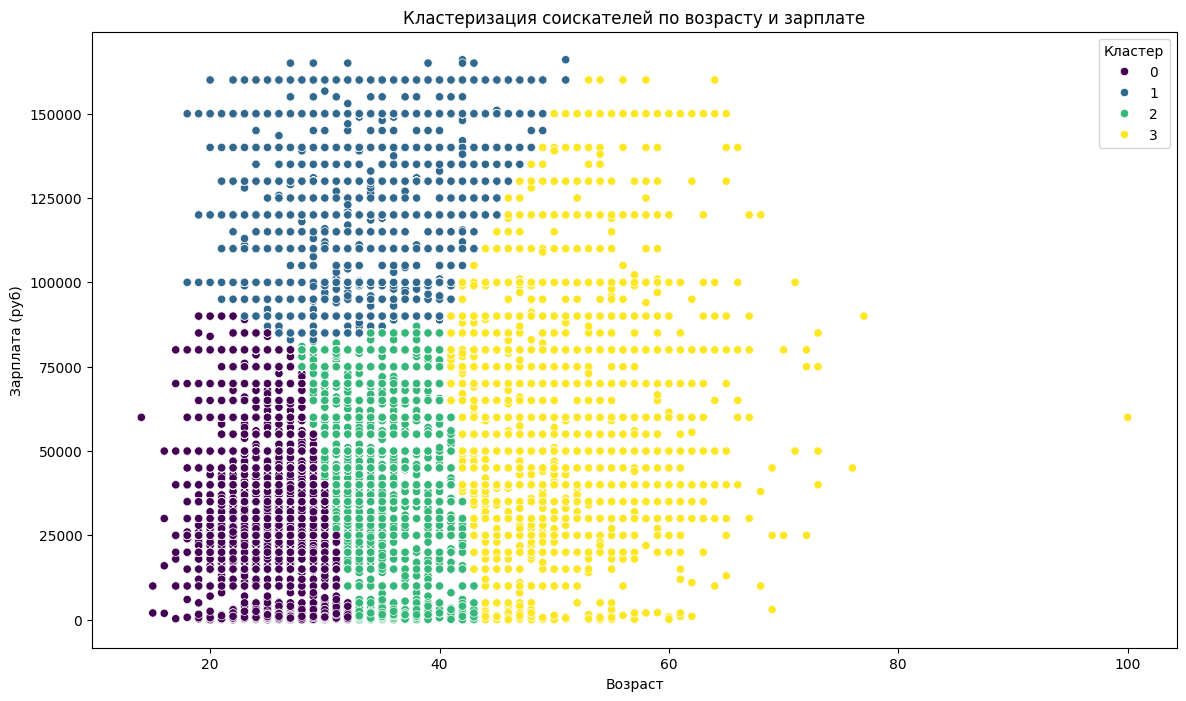

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select relevant features
cluster_data = hh_df.select("Возраст", "ЗП (руб)").toPandas()

# Drop rows with missing values
filtered_cluster_data = cluster_data.dropna()

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_cluster_data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
filtered_cluster_data["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot
plt.figure(figsize=(14, 8))
sns.scatterplot(data=filtered_cluster_data, x="Возраст", y="ЗП (руб)", hue="Cluster", palette="viridis")
plt.title("Кластеризация соискателей по возрасту и зарплате")
plt.xlabel("Возраст")
plt.ylabel("Зарплата (руб)")
plt.legend(title="Кластер")
plt.show()

lets also consider work experience "Опыт работы (месяц)" and do it in 3D

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px

# Select relevant features
cluster_data = hh_df.select("Возраст", "ЗП (руб)", "Опыт работы (месяц)").toPandas()

# Drop rows with missing values
filtered_cluster_data = cluster_data.dropna()

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_cluster_data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
filtered_cluster_data["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot 3D scatter plot
fig = px.scatter_3d(filtered_cluster_data, x='Возраст', y='ЗП (руб)', z='Опыт работы (месяц)',
                    color='Cluster', title="Кластеризация соискателей по возрасту, зарплате и опыту работы",
                    labels={"Возраст": "Возраст", "ЗП (руб)": "Зарплата (руб)", "Опыт работы (месяц)": "Опыт работы (месяц)"})
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## 6.13. Predicting Salary

### Linear Regression


In [ ]:
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

# Fill missing values
hh_df = hh_df.fillna({
    "Возраст": hh_df.agg(F.avg(col("Возраст"))).first()[0],
    "ЗП (руб)": hh_df.agg(F.avg(col("ЗП (руб)"))).first()[0],
    "Опыт работы (месяц)": hh_df.agg(F.avg(col("Опыт работы (месяц)"))).first()[0],
    "Образование": "не указано",
    "Город": "не указано",
    "Пол": "не указано"
})

# One-hot encode categorical variables for education
hh_df = hh_df.withColumn("Высшее образование", when(col("Образование") == "высшее", 1).otherwise(0))
hh_df = hh_df.withColumn("Неоконченное высшее", when(col("Образование") == "неоконченное высшее", 1).otherwise(0))
hh_df = hh_df.withColumn("Среднее специальное", when(col("Образование") == "среднее специальное", 1).otherwise(0))
hh_df = hh_df.withColumn("Среднее", when(col("Образование") == "среднее", 1).otherwise(0))

# One-hot encode categorical variables for gender
hh_df = hh_df.withColumn("Мужчина", when(col("Пол") == "Мужчина", 1).otherwise(0))
hh_df = hh_df.withColumn("Женщина", when(col("Пол") == "Женщина", 1).otherwise(0))

# One-hot encode categorical variables for city
hh_df = hh_df.withColumn("Москва", when(col("Город") == "Москва", 1).otherwise(0))
hh_df = hh_df.withColumn("Другие города", when(col("Город") != "Москва", 1).otherwise(0))

# Drop the original categorical columns
hh_df = hh_df.drop("Образование", "Пол", "Город")

# Select features and label
features = ["Возраст", "Опыт работы (месяц)", "Высшее образование", "Неоконченное высшее", "Среднее специальное", "Среднее", "Мужчина", "Женщина", "Москва", "Другие города"]
label = "ЗП (руб)"

# Assemble features vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(hh_df).select("features", col(label).alias("label"))


In [ ]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.regression import LinearRegression

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="label")

# Fit the model on the training data
lr_model = lr.fit(train_data)

# Predict on the test data
predictions = lr_model.transform(test_data)

# Show predictions
predictions.select("features", "label", "prediction").show(5)

+--------------------+-------+-----------------+
|            features|  label|       prediction|
+--------------------+-------+-----------------+
|(10,[0,1,2,6,8],[...|80000.0|75354.48587559644|
|(10,[0,1,2,6,8],[...|30000.0|76372.82193690463|
|(10,[0,1,2,6,8],[...|30000.0|76094.51865045576|
|(10,[0,1,2,6,8],[...|40000.0| 75781.4274532008|
|(10,[0,1,2,6,8],[...|40000.0|77182.43053337617|
+--------------------+-------+-----------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

# Calculate Mean Absolute Error (MAE)
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 24496.851292482046
R-squared: 0.21433913664554882


### Random Forest Regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Initialize the Random Forest model
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100, maxDepth=10)

# Fit the model on the training data
rf_model = rf.fit(train_data)

# Predict on the test data
predictions = rf_model.transform(test_data)

# Show predictions
predictions.select("features", "label", "prediction").show(5)

+--------------------+-------+------------------+
|            features|  label|        prediction|
+--------------------+-------+------------------+
|(10,[0,1,2,6,8],[...|80000.0| 61440.69439513327|
|(10,[0,1,2,6,8],[...|30000.0|41433.477240743305|
|(10,[0,1,2,6,8],[...|30000.0| 64822.00434916716|
|(10,[0,1,2,6,8],[...|40000.0| 61258.47213709124|
|(10,[0,1,2,6,8],[...|40000.0| 54842.70411274605|
+--------------------+-------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

# Calculate Mean Absolute Error (MAE)
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 24122.217841642705
R-squared: 0.23464596282299


a little bit better than Linear Regression, so lets do hyper parameters fine tuning and Cross Validation

### Hyperparameter Tuning with Cross-Validation

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create a ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

# Initialize the CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
cv_model = cv.fit(train_data)

# Use test set to measure the accuracy of the model on new data
cv_predictions = cv_model.transform(test_data)

# Evaluate the best model
mae = evaluator.evaluate(cv_predictions)
r2 = evaluator.evaluate(cv_predictions, {evaluator.metricName: "r2"})
print(f"Best Model Mean Absolute Error (MAE): {mae}")
print(f"Best Model R-squared: {r2}")

Best Model Mean Absolute Error (MAE): 24122.217841642705
Best Model R-squared: 0.23464596282299


**It looks like even with the Random Forest model and hyperparameter tuning, the model performance is not significantly improving**

### Gradient Boosting


In [ ]:
from pyspark.ml.regression import GBTRegressor

# Initialize the Gradient Boosted Trees Regressor
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100)

# Fit the model on the training data
gbt_model = gbt.fit(train_data)

# Predict on the test data
predictions = gbt_model.transform(test_data)

# Show predictions
predictions.select("features", "label", "prediction").show(5)

+--------------------+-------+------------------+
|            features|  label|        prediction|
+--------------------+-------+------------------+
|(10,[0,1,2,6,8],[...|80000.0|43769.949809833124|
|(10,[0,1,2,6,8],[...|30000.0| 52046.80025354207|
|(10,[0,1,2,6,8],[...|30000.0| 67564.34427598979|
|(10,[0,1,2,6,8],[...|40000.0|  62742.8953491662|
|(10,[0,1,2,6,8],[...|40000.0| 52046.80025354207|
+--------------------+-------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")

# Calculate Mean Absolute Error (MAE)
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 24174.62439323907
R-squared: 0.22882938204495162


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create a ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10])
             .addGrid(gbt.maxIter, [50, 100])
             .build())

# Initialize the CrossValidator
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
cv_model = cv.fit(train_data)

# Use test set to measure the accuracy of the model on new data
cv_predictions = cv_model.transform(test_data)

# Evaluate the best model
mae = evaluator.evaluate(cv_predictions)
r2 = evaluator.evaluate(cv_predictions, {evaluator.metricName: "r2"})
print(f"Best Model Mean Absolute Error (MAE): {mae}")
print(f"Best Model R-squared: {r2}")

Best Model Mean Absolute Error (MAE): 24123.81216339486
Best Model R-squared: 0.23286379062970664


**the poor performance of the models can be justified due to the high variability and subjective nature of salary expectations, as well as potential uncaptured factors**

> Individuals might have different expectations based on personal perceptions, which may not align with typical market salaries.

> The dataset likely includes a wide range of job roles with varying salary ranges, contributing to high variability

> Even within the same job role, varying levels of experience and expertise can lead to different salary expectations

>  dataset includes the city but might not capture specific factors like cost of living, which significantly affect salary.

> Salaries vary widely based on company size and industry, which might not be captured in the dataset.

> Specific skills and specializations can command different salary levels, which may not be fully captured by the features used.